## K-Means Cluster Analysis of Fidelity Fund Returns 
### University of Virginia
### DS 7200: Distributed Computing
### Last Updated: August 20, 2023

## Instructions

In this assignment, you will conduct a k-means cluster analysis on a set of Fidelity mutual funds.  
This helps to group similar funds based on their performance (as opposed to their description, which is typical).  
The outline below will walk you through the required steps.  

This assignment is worth a total of **10 POINTS.**

## Data Details 

The file *fido_returns_funds_on_rows.csv* is the processed data for k-means. Additional details about this file: 
- Each row represents a mutual fund  
- Each column represents a trading day (these are used as features)  
- Each value represents the daily percentage change in price between the current trading day and previous trading day

### Load Modules and Read Data into Spark DataFrame

In [15]:
from pyspark.sql import *
DATA_FILEPATH = 'fido_returns_funds_on_rows.csv'

spark = SparkSession \
    .builder \
    .appName("Mutual Funds") \
    .getOrCreate()

df = spark.read.csv(DATA_FILEPATH,  inferSchema=True, header = True)

**(VALUE: 2 POINTS) Assemble the Features into a column. 
Show the first five rows of data ONLY for the features column.
(this should make things easier to read)**

In [19]:
from pyspark.ml.feature import VectorAssembler

# inputCols take a list of column names
# outputCol is arbitrary name of new column; generally called features
cols = df.columns
assembler = VectorAssembler(inputCols=cols,
                            outputCol="features")
tr = assembler.transform(df)
tr.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



**(VALUE: 1 POINT) Set up the k-means model and train the model**  
Use parameters: 
- 3 clusters
- maximum of 10 iterations 
- seed=314

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
kmeans = KMeans().setK(3).setSeed(314).setMaxIter(10)
model = kmeans.fit(tr)
predictions = model.transform(tr)

23/09/27 14:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


**(VALUE: 2 POINTS) Compute and Print the Silhouette Score**  

In [22]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.42290918461227944


**(VALUE: 2 POINTS) Define a function `kmeans_range()` that does the following:**
- takes an integer representing the lower bound for k
- takes an integer representing the upper bound for k
- take a Spark DataFrame containing training data
- fit K-means with k ranging from lower bound to upper bound, inclusive  
- the other parameters should be the same as earlier 
- for each k, compute the silhouette score
- return a pandas dataframe with columns containing k, silhouette score (each row holds the score for given k)

In [25]:
import pandas as pd
def kmeans_range(df, low, high):
    df_list = []
    for i in range(low, high+1):
        kmeans = KMeans().setK(i).setSeed(314).setMaxIter(10)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        df_list.append({'K': i, "Silhouette Score": silhouette})
    df = pd.DataFrame.from_dict(df_list)
    return df

**(VALUE: 1 POINT) Call `kmeans_range` to compute K-means with clusters ranging from 2 to 10 inclusive, printing the resulting dataframe.**

In [29]:
df = kmeans_range(tr, 2, 10)
df

23/09/27 14:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB


23/09/27 14:42:37 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


23/09/27 14:42:41 WARN DAGScheduler: Broadcasting large task binary with size 1042.5 KiB


23/09/27 14:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


23/09/27 14:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB


23/09/27 14:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB


23/09/27 14:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/09/27 14:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB


23/09/27 14:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB


,K,Silhouette Score
0,2,0.602396
1,3,0.422909
2,4,0.448951
3,5,0.459352
4,6,0.468879
5,7,0.459371
6,8,0.477168
7,9,0.431599
8,10,0.438814


**(VALUE: 1 POINT) Produce a plot with cluster numbers k on the x-axis, sihouette scores on the y-axis**

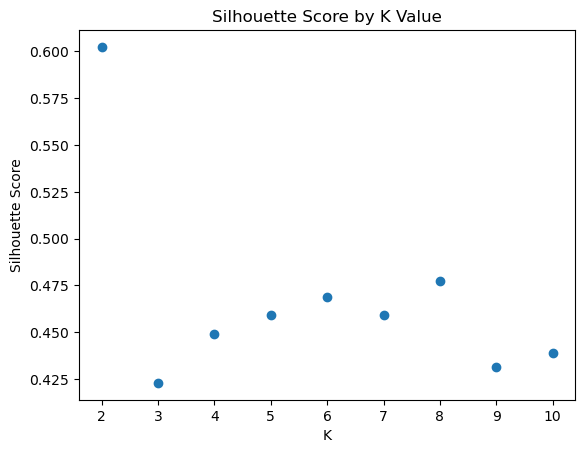

In [32]:
import matplotlib.pyplot as plt
plt.scatter(df['K'], df['Silhouette Score'])
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K Value")
plt.show()

**(VALUE: 1 POINT) Based on how the silhouette score is calculated, what is its time complexity? (e.g., O(log n))**  
You can find the definition of the silhouette score in the lecture notes, for example. 

The time complexity is $O(n^2)$. This is because for each data point (n), we have to calculate its distance from every other data point (n). This leads to $n*n$ computations of distances, leading to a time complexity of $O(n^2)$. 